# 問題1-7

In [781]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class ScratchKMeans:
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """

    def __init__(self, n_clusters, n_init, max_iter, tol=0, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.mu = None
        
        self.r = None
        self.stop_flg = False
        self.sse_list = []
        self.mu_list = []
        self.r_list = []
        self.best_sse_list = []
        self.all_sse_list=[]

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        for n_init in range(self.n_init):
            
#             print('===='+str(n_init+1) +\
#                   '回目の初期値の設定を行います。=====')
            self.stop_flg = False
            self.set_init_Mu(X)
            self.r = np.zeros((X.shape[0], self.n_clusters))

            for n_iter in range(self.max_iter):
#                 print()
#                 print('====='+str(n_iter+1) + '回目の処理を実行します=======')
#                 print()
                self.select_assignment_cluster(X)
                self.update_Mu(X)
                self.sse_list.append(self.SSE(X))
                if self.stop_flg:
                    break
            self.all_sse_list.append(np.array(self.sse_list))
            self.best_sse_list.append(self.sse_list[-1])
            self.sse_list = []
            self.mu_list.append(self.mu)
            self.r_list.append(self.r)
        #Bestのものを選出
        
        best_idx = np.argmin(self.best_sse_list)
        self.mu = self.mu_list[best_idx]
        self.r = self.r_list[best_idx]
        self.sse = self.best_sse_list[best_idx]
        #初期値を何度も変更して学習を行い、その中で最もよかった初期値での学習によるsseの経過を突っ込んでいる。
        #best_idxで取り出してきたものはndarray型なのでリストに直してsse_listに突っ込む
        self.sse_list = list(self.all_sse_list[best_idx])
        
        
        
            
        
        
        
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """

        pass
        return
    
    def set_init_Mu(self,X):
        n_cluster = self.n_clusters
        index = np.random.choice(X.shape[0],self.n_clusters)
#         print('indexの初期値を表示します。:', index)
        self.mu = X[index,:]
        
        
    def SSE(self, X):
        sse = 0
        for cluster in range(self.n_clusters):
            r_index = self.r[:,cluster] == 1
            #print(np.sum(( X[r_index,:] - self.mu[cluster])**2).shape,
              #   'clusterごと形')
            sse += np.sum(( X[r_index,:] - self.mu[cluster])**2)
        return sse
        
    
    #一番近いクラスタにデータを割り当てる関数
    def select_assignment_cluster(self,X):
        
#         print('Xの形状を表示します。',X.shape)
#         print('Muの形状を表示します。', self.mu.shape)
        
        euclid_scores = np.zeros((X.shape[0], self.n_clusters))
#         print()
#         print('ユークリッド距離の計算を開始します。')
#         print()
        for cluster in range(self.n_clusters):
#             print('----' + str(cluster + 1) + 'つめのクラスターの中心との距離--------')
#             print('muの形状を表示します。', self.mu[cluster,:].shape)
#             print('muとXの差の形状：', (X - self.mu[cluster,:]).shape)
#             print('差を2乗したものの形状:',((X - self.mu[cluster,:])**2 ).shape)
            euclid_scores[:,cluster] = np.sqrt(
                np.sum((X - self.mu[cluster,:])**2, 
                                                   axis=1))
        
        #クラスター分forを回せばできるが、回さずやりたい
        r_update_index = np.argmin(euclid_scores,axis=1)
#         print('各サンプルの割り当て先のクラスタを表示します。',
#               r_update_index )
        #print('割り当て前', self.r)
        self.r = np.zeros((X.shape[0], self.n_clusters))
        for cluster in range(self.n_clusters):
            update_index = r_update_index == cluster
            self.r[update_index, cluster] = 1
            
        
#         print()
#         print()
        #print('割り当て結果を表示します。', self.r)
        
    #中心点を移動する関数
    def update_Mu(self,X):
        center_of_gravity = np.zeros_like(self.mu)
        for cluster in range(self.n_clusters):
            c_index = self.r[:,cluster] == 1
            center_of_gravity[cluster,:] = np.mean(X[c_index,:],axis=0)
        
        #重心とmuの距離を比較する
#         print('center_of_gravityの表示：',center_of_gravity)
#         print('muの表示：',self.mu)
#         print('クラスタごとユークリッド距離',
#               np.sum((self.mu - center_of_gravity)**2,axis=1)) 
#         print('距離の平均:', np.mean(np.sum((self.mu - center_of_gravity)**2,
#                                        axis=1)))
        
        grav_mu_mean = np.mean(np.sum((self.mu - center_of_gravity)**2,
                                       axis=1))
        
        
        #それぞれの重心とのクラスタの距離の平均をとる
        if  grav_mu_mean < self.tol:
#             print('距離の平均が閾値より小さくなったので処理を停止します。')
            self.stop_flg = True

        self.mu = center_of_gravity
        
        

In [669]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [782]:
#self, n_clusters, n_init, max_iter, tol, verbose=False
skm = ScratchKMeans(n_clusters = 3, n_init = 5, max_iter=4,
                   tol=0)

In [783]:
skm.fit(X)

In [784]:
print(type(skm.sse_list))
print(skm.sse_list)

<class 'list'>
[192.09063106589338, 139.17097772033804, 139.17097772033804, 139.17097772033804]


In [672]:
skm.mu

array([[-1.26811733,  7.76378266],
       [-0.27678616,  3.72096344],
       [ 1.99186903,  0.96561071]])

In [673]:
skm.mu_list

[array([[-1.26811733,  7.76378266],
        [-0.27678616,  3.72096344],
        [ 1.99186903,  0.96561071]]), array([[-0.27678616,  3.72096344],
        [ 1.99186903,  0.96561071],
        [-1.26811733,  7.76378266]]), array([[-1.26811733,  7.76378266],
        [ 1.99186903,  0.96561071],
        [-0.27678616,  3.72096344]]), array([[-1.08819277,  5.36866827],
        [ 2.0136675 ,  0.92794973],
        [ 1.05786919,  3.92385851]]), array([[-0.45457683,  3.60484499],
        [ 1.99645666,  1.06603355],
        [-0.93784245,  7.39131412]])]

In [674]:
skm.sse_list

array([227.40947165, 167.81999175, 139.89987953, 139.17097772])

In [675]:
print(skm.best_sse_list)
best_idx =np.argmin(skm.best_sse_list)
print(skm.best_sse_list[best_idx])

[139.17097772033804, 139.17097772033804, 139.17097772033804, 349.2311624250357, 167.8199917459912]
139.17097772033804


In [676]:
skm.all_sse_list

[array([227.40947165, 167.81999175, 139.89987953, 139.17097772]),
 array([219.07231682, 165.09503863, 139.89987953, 139.17097772]),
 array([139.17097772, 139.17097772, 139.17097772, 139.17097772]),
 array([424.98554445, 413.74482518, 404.86773659, 349.23116243]),
 array([267.61010428, 240.55958725, 228.25951957, 167.81999175])]

In [677]:
test_r = np.zeros((5,3))
test_idx =np.array([0,1,2,1,2])



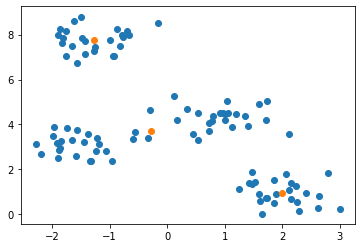

In [678]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(skm.mu[:,0],skm.mu[:,1])

In [679]:
skm.best_sse_list

[139.17097772033804,
 139.17097772033804,
 139.17097772033804,
 349.2311624250357,
 167.8199917459912]

In [680]:
skm.all_sse_list

[array([227.40947165, 167.81999175, 139.89987953, 139.17097772]),
 array([219.07231682, 165.09503863, 139.89987953, 139.17097772]),
 array([139.17097772, 139.17097772, 139.17097772, 139.17097772]),
 array([424.98554445, 413.74482518, 404.86773659, 349.23116243]),
 array([267.61010428, 240.55958725, 228.25951957, 167.81999175])]

In [681]:
#更新回数を10回に増やす
skm_2 = ScratchKMeans(n_clusters = 3, n_init = 5, max_iter=10,
                   tol=0)

In [682]:
skm_2.fit(X)

In [683]:
skm_2.best_sse_list

[139.17097772033804,
 347.4358845684245,
 240.95117095940685,
 139.17097772033804,
 139.17097772033804]

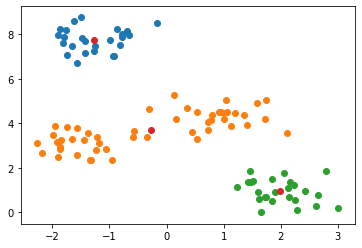

In [684]:
for n in range(skm_2.n_clusters):
    plt.scatter(X[skm_2.r[:,n] == 1,0],X[skm_2.r[:,n] == 1,1])
plt.scatter(skm_2.mu[:,0],skm_2.mu[:,1])

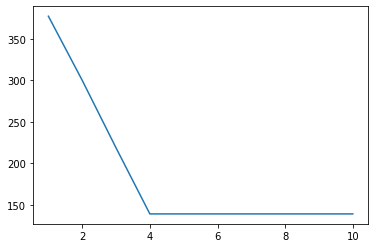

In [685]:

plt.plot(np.arange(1,len(skm_2.sse_list)+1),np.array(skm_2.sse_list))

In [686]:
#クラスタ数を4つ、更新回数を10回に増やす

skm_3 = ScratchKMeans(n_clusters = 4, n_init = 20, max_iter=10,
                   tol=0)
skm_3.fit(X)

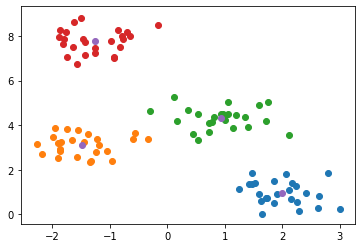

In [687]:
for n in range(skm_3.n_clusters):
    plt.scatter(X[skm_3.r[:,n] == 1,0],X[skm_3.r[:,n] == 1,1])
plt.scatter(skm_3.mu[:,0],skm_3.mu[:,1])

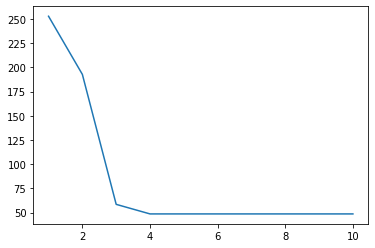

In [688]:
 skm_3.sse_list
plt.plot(np.arange(1,len(skm_3.sse_list)+1),np.array(skm_3.sse_list))

In [689]:
skm_3.sse

48.63378320706402

In [690]:
#閾値を設定
skm_4 = ScratchKMeans(n_clusters = 4, n_init = 10, max_iter=10,
                   tol=0.05)
skm_4.fit(X)

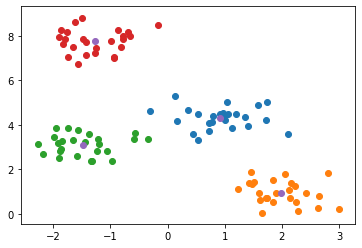

In [691]:
for n in range(skm_4.n_clusters):
    plt.scatter(X[skm_4.r[:,n] == 1,0],X[skm_4.r[:,n] == 1,1])
plt.scatter(skm_4.mu[:,0],skm_4.mu[:,1])

In [692]:
skm_4.sse_list

array([215.50861439,  48.63378321,  48.63378321])

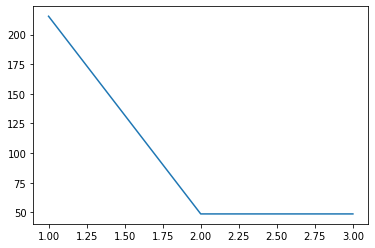

In [693]:
plt.plot(np.arange(1,len(skm_4.sse_list)+1),np.array(skm_4.sse_list))

# 問題8 エルボー法の実装

In [694]:
def elbor(X, max_k, n_init=10,max_iter=10,tol=0.0001):
    k_best_sse = []
    k_best_mu = []
    k_best_r = []
    k_best_estimator = []
    
    for k in range(max_k):
        k_means = ScratchKMeans(n_clusters = k+1, n_init = n_init,
                                max_iter=max_iter, tol=tol)
        k_means.fit(X)
        k_best_sse.append(k_means.sse)
        k_best_mu.append(k_means.mu)
        k_best_r.append(k_means.r)
        k_best_estimator.append(k_means)
    
    best_of_best_idx= np.argmin(k_best_sse)
    best_of_best_sse = k_best_sse[best_of_best_idx]
    best_of_best_mu = k_best_mu[best_of_best_idx]
    best_of_best_r = k_best_r[best_of_best_idx]
    best_of_best_estimator = k_best_estimator[best_of_best_idx]
    
    dict_best_of_best = {}
    dict_best_of_best['sse'] = best_of_best_sse
    dict_best_of_best['mu'] = best_of_best_mu
    dict_best_of_best['r'] = best_of_best_r
    dict_best_of_best['estimator'] = best_of_best_estimator
    
    plt.plot(np.arange(1,len(k_best_sse)+1), k_best_sse)
    plt.xlabel('number of cluster')
    plt.ylabel('SSE')
    return dict_best_of_best
    
        
    
    

{'sse': 43.00519867163702, 'mu': array([[ 1.06148307,  4.39922699],
        [ 1.99186903,  0.96561071],
        [-1.26811733,  7.76378266],
        [-1.61318321,  3.06863899],
        [-0.09148886,  3.73633536]]), 'r': array([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
  

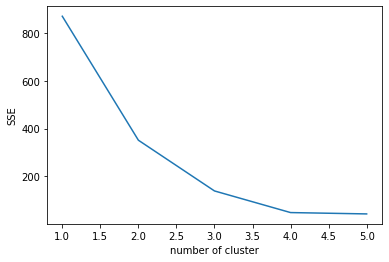

In [695]:
elbor(X,max_k = 5)

# 問題9 （アドバンス課題）シルエット図

In [740]:
from matplotlib import cm
def plot_Silhouette(skm, X):
    
    
    #まずシルエット係数を求める
    silhouette_vals = np.zeros(X.shape[0])
    for idx in range(X.shape[0]):
        xn = X[idx]
        class_idx = np.argmax(skm.r[idx,:])#所属するクラスのインデックス
        cluster_idx = skm.r[:,class_idx] == 1
        X_cluster = X[cluster_idx]
        an = np.mean(np.sum((xn - X_cluster)**2, 1))
        if idx < 5:
            print('an', an)
        #print(np.sum((skm_4.mu[class_idx,:] - skm_4.mu)**2,
                               #           axis=1))
        near_class_idx =np.argsort(np.sum((skm.mu[class_idx,:] - \
                                           skm.mu)**2,axis=1))[-2]
        cluster_near_idx  = skm.r[:,near_class_idx] == 1
        X_cluster_near = X[cluster_near_idx]
        bn = np.mean(np.sum((xn - X_cluster_near)**2, 1))
        if idx < 5:
            print('bn', bn)

        silhouette_vals[idx] = (bn - an)/ max(an,bn)
    print(silhouette_vals[:5])

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    y_km = np.argmax(skm.r,axis=1)
    n_clusters = skm.r.shape[1]
    cluster_labels = np.arange(n_clusters)
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

an 3.295705976101689
bn 9.642807203130328
an 0.9242345279016684
bn 22.963622141241764
an 5.383204605637376
bn 12.433248618620578
an 4.666484508031974
bn 13.798251968469001
an 7.192402849775444
bn 16.155596718849345
[0.65822131 0.95975223 0.56703153 0.66180611 0.55480426]


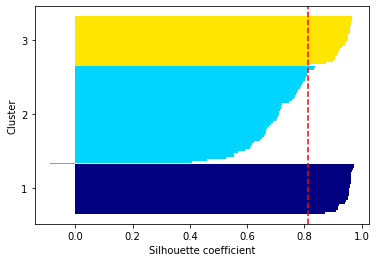

In [741]:
plot_Silhouette(skm_2, X)

縦軸の長さは、そのクラスタに属するデータ比率を表す
縦軸は各クラスタに属するデータのsnをソートして並べたものである。
snは１に近いほど他クラスとの乖離度が大きくなり、凝集度が小さくなる。

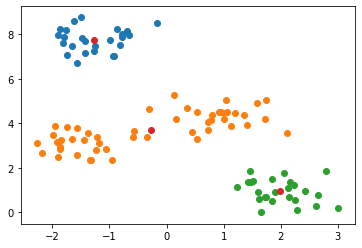

In [698]:
for n in range(skm_2.n_clusters):
    plt.scatter(X[skm_2.r[:,n] == 1,0],X[skm_2.r[:,n] == 1,1])
plt.scatter(skm_2.mu[:,0],skm_2.mu[:,1])

In [699]:
test_t = np.zeros(3)
test_t[2] = 1
test_t
xr = np.argmax(test_t)
print(xr)


2


# 卸売業者のデータ分析

In [700]:
import pandas as pd

data = pd.read_csv('../Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [701]:
idx = np.array([0,1])
data_updated = data.drop(['Channel','Region'], axis=1)
data_updated.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [702]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data_updated)
data_pca = pca.transform(data_updated)

In [703]:
data_pca

array([[ 6.50022122e+02,  1.58551909e+03],
       [-4.42680498e+03,  4.04245151e+03],
       [-4.84199871e+03,  2.57876218e+03],
       [ 9.90346437e+02, -6.27980600e+03],
       [ 1.06579987e+04, -2.15972582e+03],
       [-2.76596159e+03, -9.59870727e+02],
       [-7.15550892e+02, -2.01300227e+03],
       [-4.47458367e+03,  1.42949697e+03],
       [-6.71209540e+03, -2.20590916e+03],
       [-4.82363435e+03,  1.34805592e+04],
       [-7.97482898e+03,  5.71121893e+03],
       [ 3.63937790e+01, -6.03789641e+03],
       [ 1.99402021e+04,  4.59128648e+03],
       [ 9.39669558e+03,  5.91315704e+03],
       [ 1.26603704e+04,  4.54194543e+03],
       [-2.99772590e+03, -6.09387930e+03],
       [-1.05895236e+04,  6.58421594e+03],
       [-6.36709518e+03, -3.68071267e+03],
       [ 6.62382534e+03,  1.25471953e+03],
       [-4.86153157e+03, -2.25592266e+02],
       [ 4.79424416e+03, -3.98879936e+03],
       [-7.24486684e+03, -7.34772325e+03],
       [ 1.92992657e+04, -6.93681068e+03],
       [ 1.

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


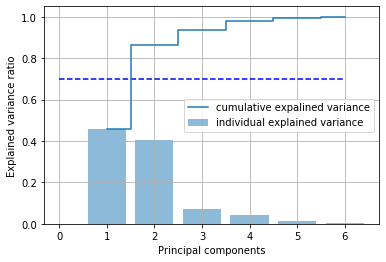

In [704]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data_updated)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 問題10 クラスタ数kの選択

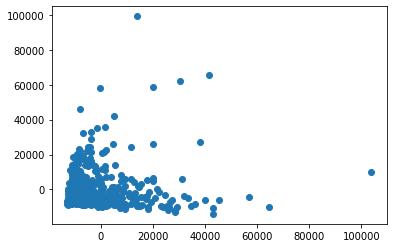

In [705]:
plt.scatter(data_pca[:,0], data_pca[:,1])

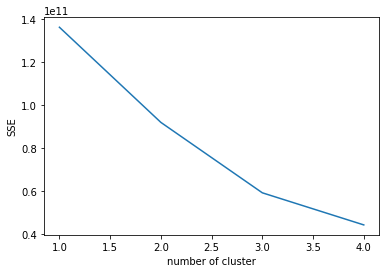

In [706]:
dict_best_of_best = elbor(data_pca, max_k = 4)

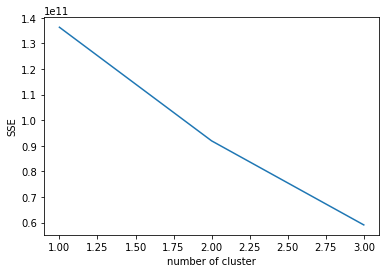

In [707]:
#エルボー法
dict_best_of_best_k3 = elbor(data_pca, max_k = 3)
elbor_estimator_k3 = dict_best_of_best_k3['estimator']

In [708]:
def plot_scatter(X,estimator):
    for n in range(estimator.n_clusters):
        plt.scatter(X[estimator.r[:,n] == 1,0],
                    X[estimator.r[:,n] == 1,1],label=n+1)
        plt.scatter(estimator.mu[n,0],estimator.mu[n,1])

    plt.legend()



In [711]:
def plot_all_scatter(X, k_region):
    length = k_region[1] - k_region[0]+1
    plt.figure(1,figsize=(30, 10*length))
    count = 1
    for k in range(k_region[0], k_region[1]+1):
#         print(k,'kの値')
#         print('subplotの値：',k - k_region[0] + count )
        plt.subplot(length, 2, k - k_region[0] + count)
        plt.title('elbor cluster = ' + str(k))
        count += 1
        dict_best_of_best = elbor(X, max_k = k)
        elbor_estimator = dict_best_of_best['estimator']
        plt.subplot(length, 2, k - k_region[0] + count)
        plt.title('scatter cluster='+str(k))
        plot_scatter(X,elbor_estimator)
        
        

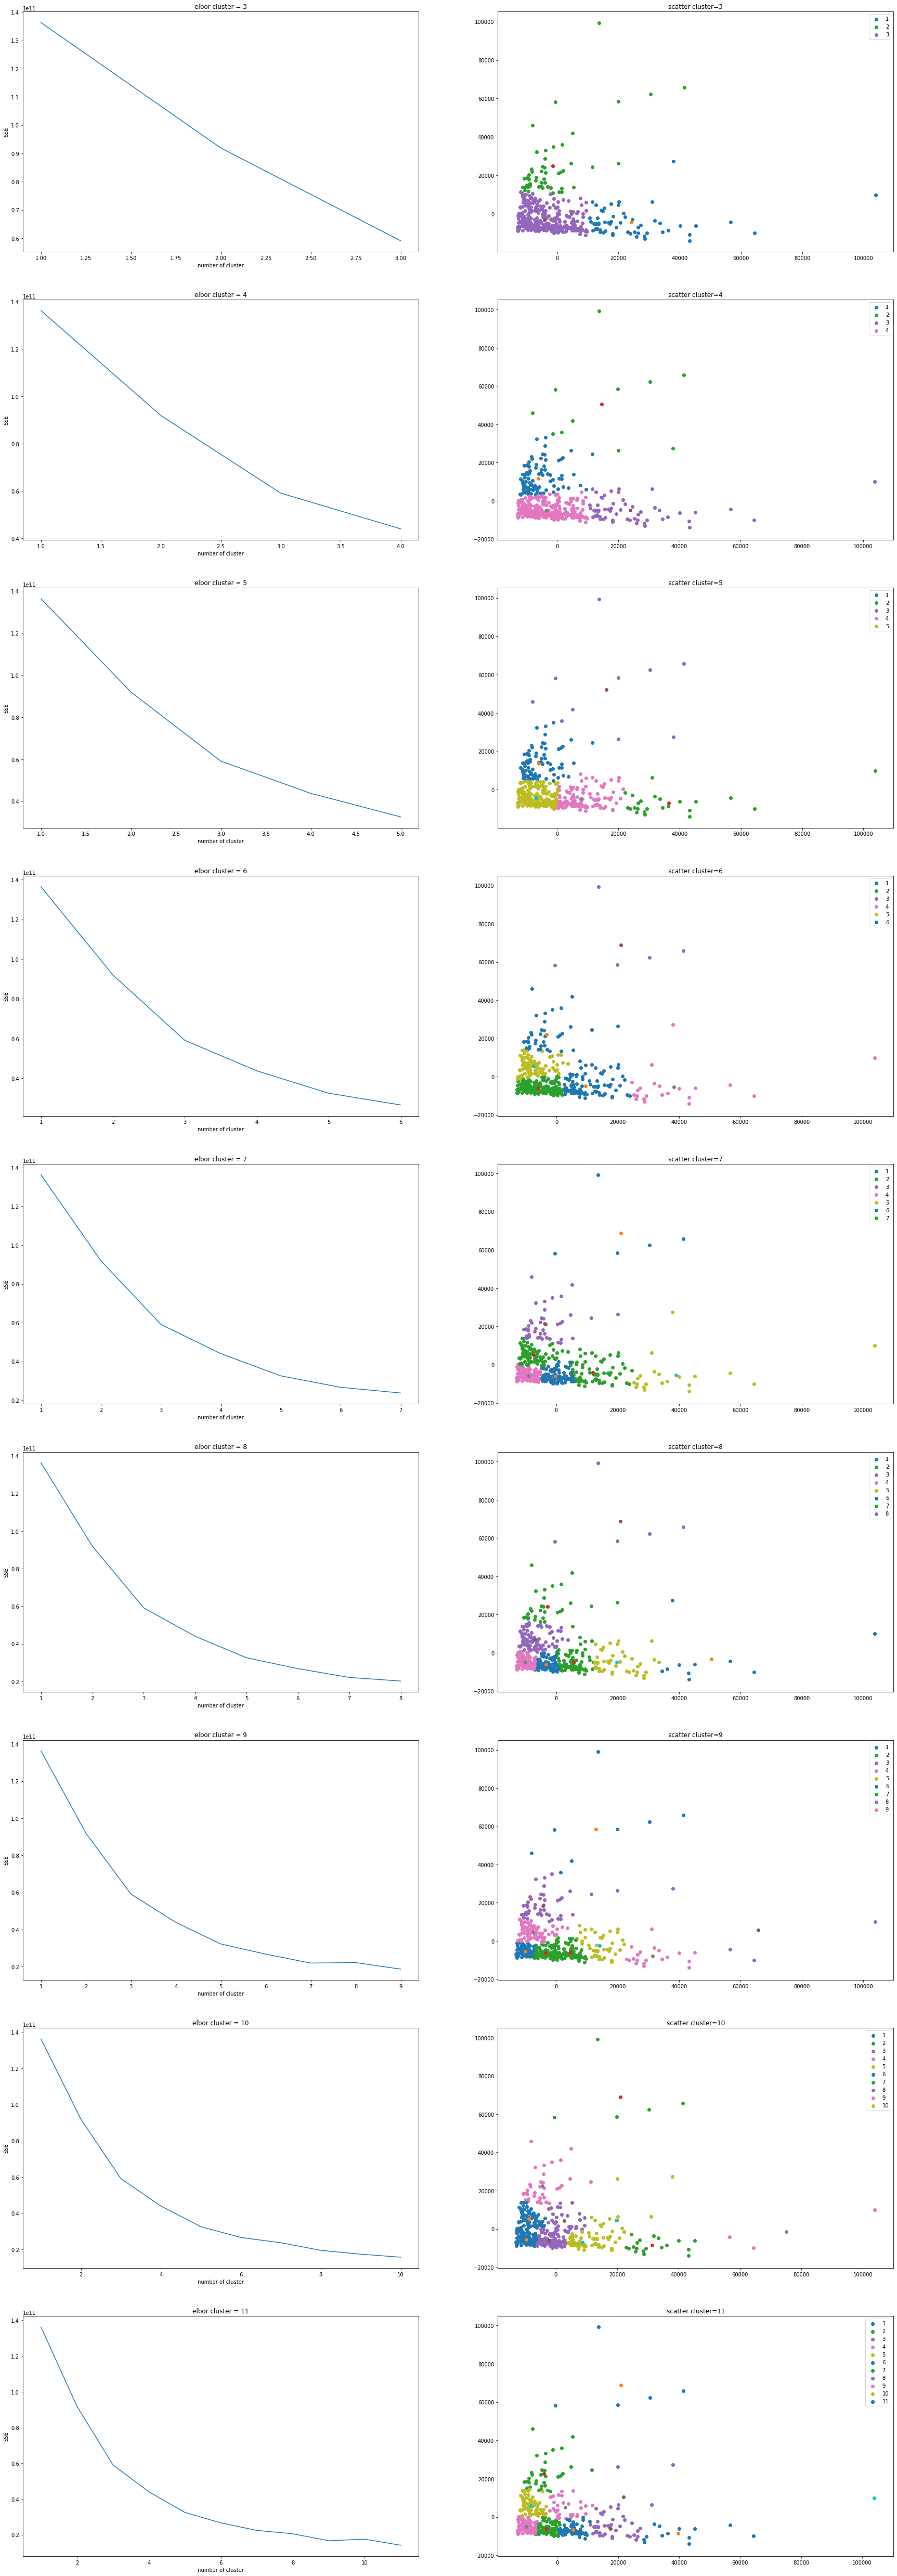

In [712]:
list_k = [3,11]
plot_all_scatter(data_pca, list_k)

エルボーの結果をみると、クラスタ数が７までであれば順当にSSEが下がり続けるが、８以上になると下がり幅が低下するのがわかる。
またクラスタ数を多くしすぎると、クラスタ内データ数＝１のクラスタができてしまい、有意な解釈が得られなくなることが
クラスタ別の散布図からもわかる。

[ 0.88287472  0.86010131  0.89069006  0.92649067 -0.40262444]


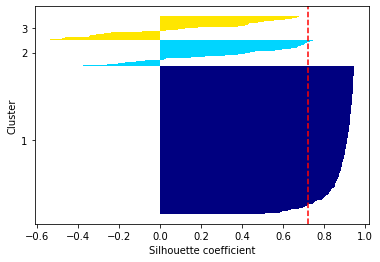

In [713]:


plot_Silhouette(elbor_estimator, data_pca)

In [732]:
'''
学習済みの分類器のリスト、データを引数に受け取る

'''


def plot_all_Silhouette(estimator_list, data_pca):
    start_k = estimator_list[0].n_clusters
    
    for idx,estimator in enumerate(estimator_list):
        plt.title('Silhouette cluster=' + str(start_k + idx))
        plot_Silhouette(estimator, data_pca)
        
        

In [733]:
def generate_k_means(data, k_range):
    start = k_range[0]
    last = k_range[1]
    skm_list = []
    for k in range(start, last+1):
        skm = ScratchKMeans(n_clusters = k, n_init = 20, max_iter=10,
                   tol=0)
        skm.fit(data)
        skm_list.append(skm)
        
    return skm_list
        

In [786]:
k_range = [2,11]
skm_list = generate_k_means(data_pca, k_range)

an 161157961.9893783
bn 161157961.9893783
an 152802482.68868282
bn 152802482.68868282
an 142874186.9087395
bn 142874186.9087395
an 198158687.60657588
bn 198158687.60657588
an 829132507.7272725
bn 829132507.7272725
[0. 0. 0. 0. 0.]


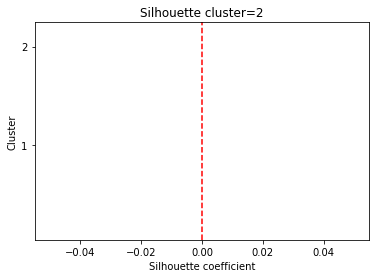

an 110912202.24745528
bn 946953566.0261252
an 117782897.38935915
bn 841915638.5613352
an 99254384.43258704
bn 908008810.6012571
an 101346728.73991777
bn 1378692098.4107347
an 476590925.97525966
bn 284703770.3993048
[ 0.88287472  0.86010131  0.89069006  0.92649067 -0.40262444]


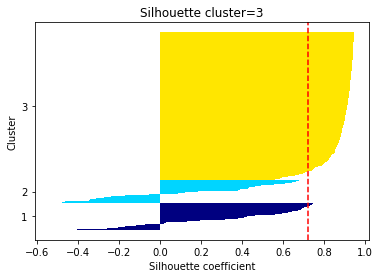

an 109837957.85888445
bn 878762519.1247396
an 170796243.0806338
bn 1179139214.0193048
an 107896831.82431217
bn 1180632324.4138792
an 72071389.34407535
bn 831101350.4047153
an 476590925.97525966
bn 582471096.2401273
[0.87500837 0.85515176 0.90861098 0.91328207 0.18177755]


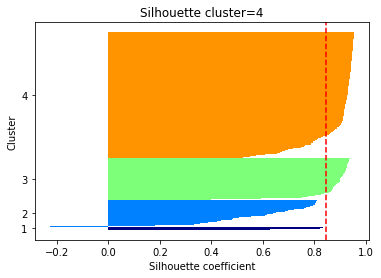

an 115404450.29905933
bn 1655433171.0243425
an 95559725.84604527
bn 2079014846.0046728
an 73863641.04292
bn 2087586870.4724126
an 96128088.03093873
bn 1585648469.1111772
an 65701759.980819695
bn 1012364033.8211625
[0.93028746 0.95403605 0.96461769 0.93937617 0.93510066]


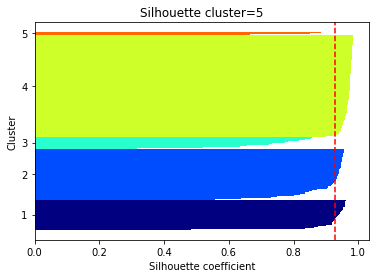

an 109719776.17306314
bn 1804722989.451201
an 40275201.03383832
bn 2247533528.9051833
an 44590248.06028038
bn 2256933448.992363
an 72083365.71783468
bn 1730204348.9756734
an 58455207.83969797
bn 891222814.1956471
[0.93920409 0.98208027 0.98024299 0.95833824 0.93441011]


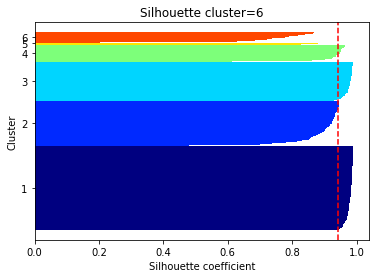

an 85118394.02532113
bn 3477330195.084799
an 38716990.25303578
bn 4070442805.4321337
an 42183253.21584331
bn 4104566433.684414
an 33950450.63644551
bn 3450245660.2665825
an 89757037.80809139
bn 2492354122.467112
[0.97552191 0.99048826 0.98972285 0.99015999 0.96398704]


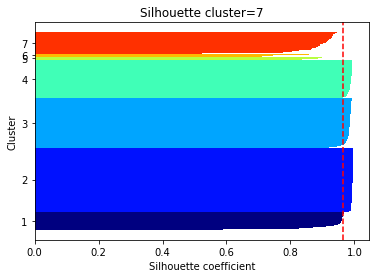

an 73522950.97471565
bn 3477330195.084799
an 46171937.30665865
bn 4070442805.4321337
an 54583220.04696593
bn 4104566433.684414
an 19502927.594525695
bn 3450245660.2665825
an 45046293.21157679
bn 2492354122.467112
[0.97885649 0.98865678 0.98670183 0.99434738 0.98192621]


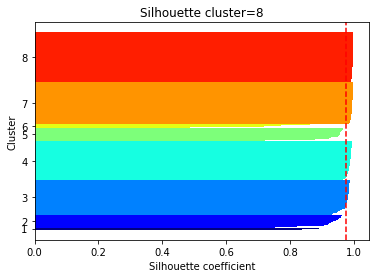

an 77348723.8758756
bn 5036823982.876076
an 41850181.90921307
bn 5284284242.986296
an 48774240.00734436
bn 5497309884.307299
an 25365554.920837656
bn 5119818341.878525
an 57963457.43248075
bn 3879735128.7424917
[0.98464335 0.99208026 0.99112762 0.99504561 0.98505994]


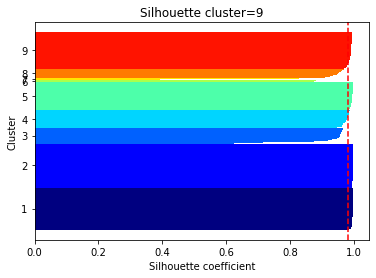

an 79938117.53538847
bn 3680987402.6769485
an 24666430.185018945
bn 4318301619.499639
an 24848116.49991673
bn 4342206794.365877
an 25219068.957967877
bn 3586946044.554221
an 49151732.33033573
bn 2618002061.289425
[0.97828351 0.99428793 0.99427754 0.99296921 0.98122548]


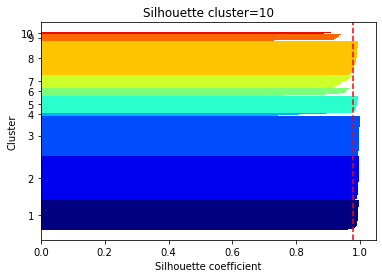

an 22413160.203886073
bn 5376583154.970496
an 41501932.426290445
bn 5284284242.986296
an 37637459.731569
bn 5497309884.307299
an 14459442.994202174
bn 6482364983.953817
an 44506115.081997775
bn 5587766306.277665
[0.99583134 0.99214616 0.99315348 0.99776942 0.99203508]


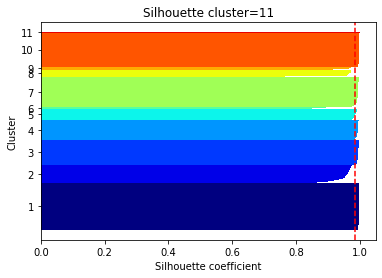

In [787]:
plot_all_Silhouette(skm_list, data_pca)

上記シルエット図から、クラスタが三つだと、Silhouette coefficientがマイナスになり、うまく分離できていないことがわかる。
一方でクラスタを増やし続けると、データ比率が微小な分離が目立つようになる。例えば、クラスタ数を11にした時は、
4番目のクラスタや９番目のクラスタのデータ比率が微小で意味のない分離をしてしまってることがわかる。
以上の結果及びクラスタ数別散布図、エルボーの結果を踏まえると、クラスタ数が５, 6個の時が最も意味のある分離をしていて、かつSilhouette coefficientの値も妥当の値を示していることから
クラスタ数は5, 6個が最も適切であると推察する

# 問題11 既知のグループとの比較

In [788]:
def plot_scatter_by_var(data_pca, data, var_name):
    #print(data.loc[:,var_name])
    #print(np.unique(data.loc[:,var_name]))
    for idx, val in enumerate(np.unique(data.loc[:,var_name])):
        plt.scatter(data_pca[data.loc[:,var_name] == val,0], data_pca[data.loc[:,var_name] == val,1], label=val,alpha=0.5)
    plt.legend(loc='best')

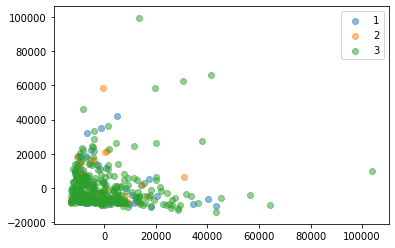

In [789]:
plot_scatter_by_var(data_pca, data, 'Region')

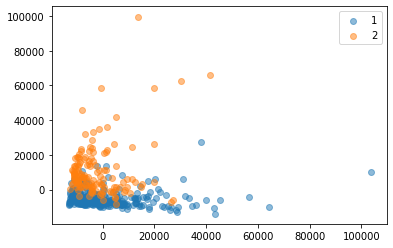

In [790]:
plot_scatter_by_var(data_pca, data, 'Channel')

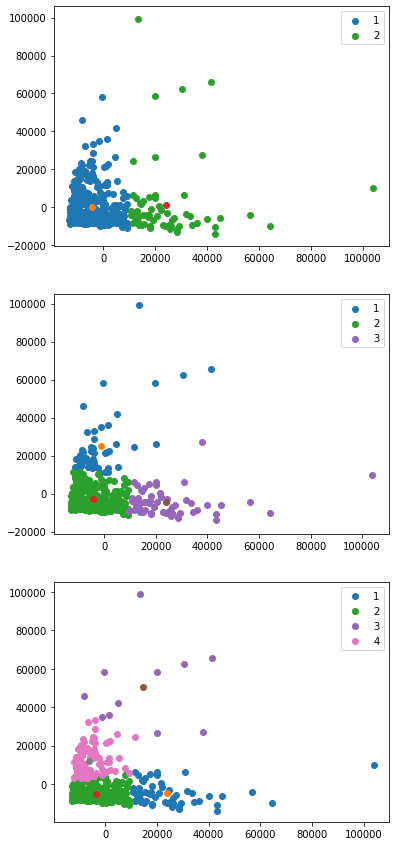

In [800]:
skm_list = generate_k_means(data_pca, [2,4])
plt.figure(1,figsize=(6,15))
for idx, skm in enumerate(skm_list):
    skm.fit(data_pca)
    plt.subplot(3,1,idx+1)
    plot_scatter(data_pca, skm)
    

channelによる分割と、claster=4の(1,2)ペアと(3,4)ペアでの分割を比較してみる

In [826]:
skm_k6 = ScratchKMeans(n_clusters = 6, n_init = 20, max_iter=10,
                   tol=0)
skm_k6.fit(data_pca)

In [887]:
def n_clusters_to_2(skm, data_pca):
    cluster_sepa_idx = skm.mu[:,1] >0
    print(cluster_sepa_idx,'sepa_idx')
    print(cluster_sepa_idx)
    new_r = np.zeros((data_pca.shape[0], 2))
    
    for idx, sepa_2_idx in enumerate(cluster_sepa_idx):
        r_mask = skm.r[:,idx] == 1
        if sepa_2_idx: 
            new_r[r_mask,0] = 1
        else:
            new_r[r_mask, 1] = 1
    print(new_r.shape, 'new_r')
    
    colors = ['red', 'blue']
    
    for idx in range(new_r.shape[1]):
        plt.scatter(data_pca[new_r[:,idx] == 1,0], data_pca[new_r[:,idx] == 1,1], color=colors[idx], label=idx+1)

    plt.title('k' + str(skm.n_clusters) + '_cluster merge to 2')
    plt.legend(loc='best')

In [894]:
def compare_cluster_channel(skm, data_pca,data):
    cluster_sepa_idx = skm.mu[:,1] >0
    new_r = np.zeros((data_pca.shape[0], 2))

    print(cluster_sepa_idx,'sepa_idx')
    print(cluster_sepa_idx)
    for idx, sepa_2_idx in enumerate(cluster_sepa_idx):
        r_mask = skm.r[:,idx] == 1
        if sepa_2_idx: 
            new_r[r_mask,0] = 1
        else:
            new_r[r_mask, 1] = 1
    print(new_r.shape, 'new_r')
            
    channel_sepa = np.zeros_like(new_r)
    channel_row = np.array(data.loc[:,'Channel'])
    channel_sepa1_idx = channel_row == 1
    channel_sepa[channel_sepa1_idx, 0] = 1
    
    channel_sepa2_idx = channel_row == 2
    channel_sepa[channel_sepa2_idx, 1] = 1
    print(channel_sepa.shape, 'channel_sepa')
    label_cluster = ['cluster=1', 'cluster=2']
    label_channel= ['Channel=1', 'Channel=2']
    count = 0
    colors = ['black', 'green', 'red', 'orange']
    print('cluster',np.sum(new_r, axis=0))
    print('channel',np.sum(channel_sepa, axis=0))
    #print(channel_sepa)
    mask_list =[]
    label_list = []
    for i, lc_cluster in enumerate(label_cluster):
        for j, lc_channel in enumerate(label_channel):

            mask = (new_r[:,i] == 1).reshape(-1,1) * (channel_sepa[:,j] == 1).reshape(-1,1)
            print(np.sum(mask == True), 'atttention')
            print(mask.shape,'mask')
            print(count)
            plt.scatter(data_pca[mask.ravel(), 0], data_pca[mask.ravel(), 1], label=lc_cluster +' and ' + lc_channel,
                       color=colors[count], alpha=0.6)
            dict_name = lc_cluster +' and ' + lc_channel
            mask_list.append(mask)
            label_list.append(lc_cluster +' and ' + lc_channel)
            count += 1
    
    plt.legend(loc='best')
    return label_list, mask_list

[False False  True False  True  True] sepa_idx
[False False  True False  True  True]
(440, 2) new_r
[False False  True False  True  True] sepa_idx
[False False  True False  True  True]
(440, 2) new_r
(440, 2) channel_sepa
cluster [127. 313.]
channel [298. 142.]
21 atttention
(440, 1) mask
0
106 atttention
(440, 1) mask
1
277 atttention
(440, 1) mask
2
36 atttention
(440, 1) mask
3


Text(0.5, 1.0, 'comparison')

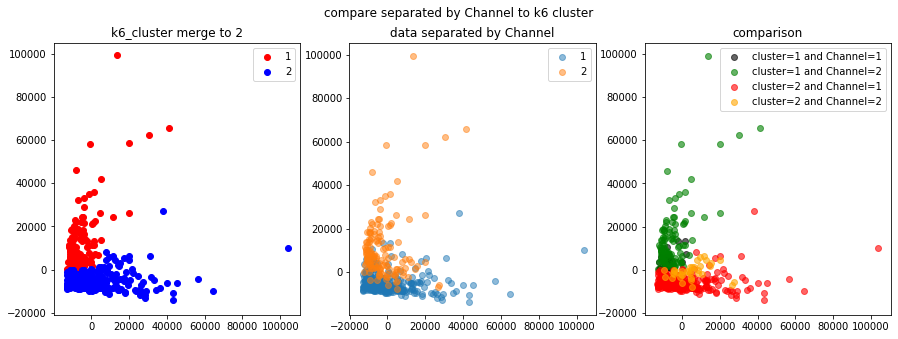

In [895]:
plt.figure(1,figsize=(15,5))
plt.suptitle('compare separated by Channel to k6 cluster')
plt.subplot(1,3,1)
n_clusters_to_2(skm_k6, data_pca)


plt.subplot(1,3,2)
plot_scatter_by_var(data_pca, data, 'Channel')
plt.title('data separated by Channel')
plt.subplot(1,3,3)
label_list, mask_list = compare_cluster_channel(skm_k6,data_pca,data)
plt.title('comparison')

クラスタ１とchannel2,クラスタ2とchannel1が対応関係にあることがわかる

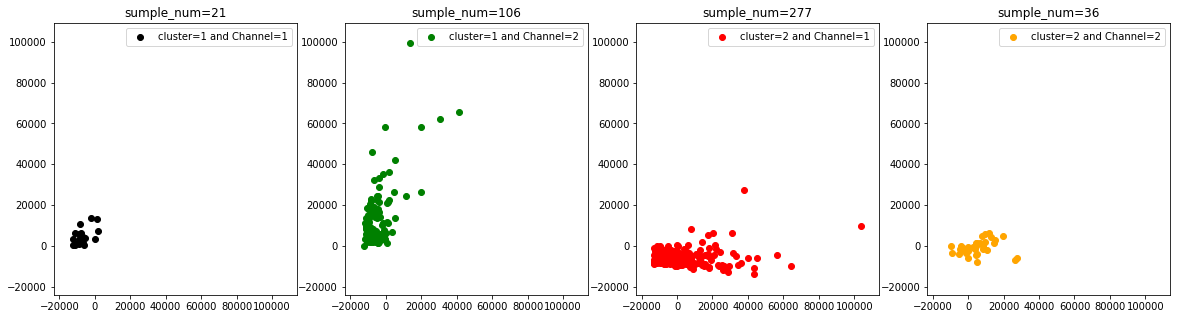

In [905]:
plt.figure(1,figsize=(20,5))
colors = ['black', 'green', 'red', 'orange'] 
count = 1
for label, mask, color in zip(label_list, mask_list, colors):
    plt.subplot(1,4, count)
    plt.scatter(data_pca[mask.ravel(),0], data_pca[mask.ravel(), 1], label=label, color = color)
    sample_num = np.sum(mask)
    plt.title('sumple_num=' + str(sample_num))
    count += 1
    plt.legend(loc='best')
    plt.xlim(data_pca[:,0].min() - 10000, data_pca[:,0].max() + 10000)
    plt.ylim(data_pca[:,1].min() - 10000, data_pca[:,1].max() + 10000)
    

In [919]:
mask_list[0].shape

(440, 1)

In [925]:
print(label_list[2])
data.loc[mask_list[2][:,0],:].mean()

cluster=2 and Channel=1


Channel                 1.000000
Region                  2.523466
Fresh               14171.368231
Milk                 2999.148014
Grocery              3498.379061
Frozen               3865.891697
Detergents_Paper      619.317690
Delicassen           1398.985560
dtype: float64

In [923]:
print(label_list[0])
data.loc[mask_list[0][:,0],:].mean()

cluster=1 and Channel=1


Channel                 1.000000
Region                  2.333333
Fresh                4297.523810
Milk                 9421.428571
Grocery             10079.333333
Frozen               2196.523810
Detergents_Paper     3049.333333
Delicassen           1639.809524
dtype: float64

In [924]:
print(label_list[1])
data.loc[mask_list[1][:,0],:].mean()

cluster=1 and Channel=2


Channel                 2.000000
Region                  2.603774
Fresh                6032.820755
Milk                12554.641509
Grocery             19150.198113
Frozen               1461.962264
Detergents_Paper     8737.235849
Delicassen           1800.481132
dtype: float64

In [926]:
print(label_list[3])
data.loc[mask_list[3][:,0],:].mean()

cluster=2 and Channel=2


Channel                 2.000000
Region                  2.638889
Fresh               17359.305556
Milk                 5304.194444
Grocery              7997.888889
Frozen               2213.972222
Detergents_Paper     2947.861111
Delicassen           1614.916667
dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

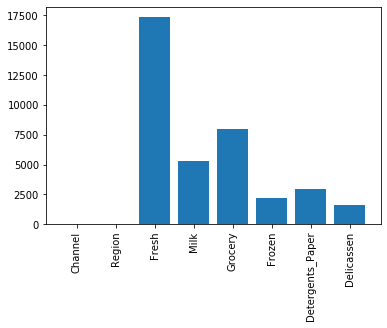

In [933]:
plt.bar(data.loc[mask_list[3][:,0],:].mean().index, data.loc[mask_list[3][:,0],:].mean(), color='blue')
plt.xticks(rotation=90)
plt.bar(data.loc[mask_list[3][:,0],:].mean().index, data.loc[mask_list[3][:,0],:].mean(), color='blue')
plt.xticks(rotation=90)

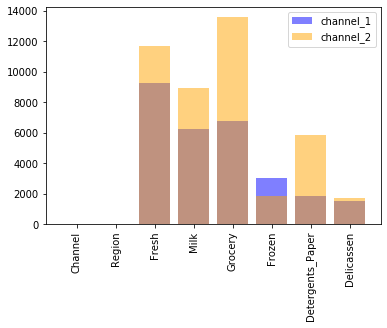

In [948]:
channel_1 = (data.loc[mask_list[0][:,0],:].mean() + data.loc[mask_list[2][:,0],:].mean())/ 2
channel_2 = (data.loc[mask_list[3][:,0],:].mean() + data.loc[mask_list[1][:,0],:].mean())/ 2
plt.bar(channel_1.index, channel_1, color='blue', label='channel_1', alpha=0.5)
plt.xticks(rotation=90)
plt.legend()
plt.bar(channel_2.index, channel_2, color='orange', label='channel_2', alpha=0.5)
plt.xticks(rotation=90)
plt.legend()

以上の結果から、channel２がfrozenを除く全ての項目でchannel1を大きく上回っており、特に、
Detergents_Paperで大きな差があることがわかる。

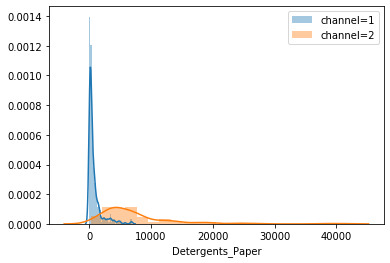

In [962]:
import seaborn as sns

sns.distplot(data.loc[data.loc[:,'Channel'] == 1,'Detergents_Paper'], label='channel=1')
sns.distplot(data.loc[data.loc[:,'Channel'] == 2,'Detergents_Paper'], label='channel=2')
plt.legend(loc='upper right')

# Channelを固定して分析してみる

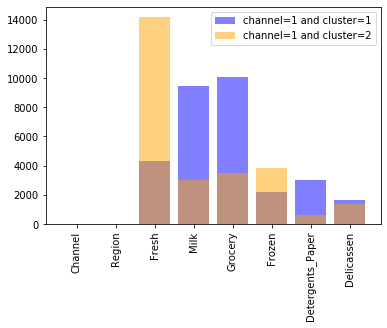

In [951]:
channel_1_cluster_1 = data.loc[mask_list[0][:,0],:].mean()
channel_1_cluster_2 = data.loc[mask_list[2][:,0],:].mean()
plt.bar(channel_1_cluster_1.index, channel_1_cluster_1, color='blue', label='channel=1 and cluster=1', alpha=0.5)
plt.xticks(rotation=90)
plt.legend()
plt.bar(channel_1_cluster_2.index, channel_1_cluster_2, color='orange', label='channel=1 and cluster=2', alpha=0.5)
plt.xticks(rotation=90)
plt.legend()

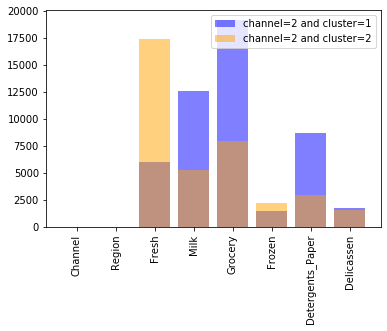

In [952]:
channel_2_cluster_1 = data.loc[mask_list[1][:,0],:].mean()
channel_2_cluster_2 = data.loc[mask_list[3][:,0],:].mean()
plt.bar(channel_2_cluster_1.index, channel_2_cluster_1, color='blue', label='channel=2 and cluster=1', alpha=0.5)
plt.xticks(rotation=90)
plt.legend()
plt.bar(channel_2_cluster_2.index, channel_2_cluster_2, color='orange', label='channel=2 and cluster=2', alpha=0.5)
plt.xticks(rotation=90)
plt.legend()

クラスタ1では、Milk, grocery, Detergents_paperが大きく、クラスタ2では、Freshとfrozenが大きいことがわかる

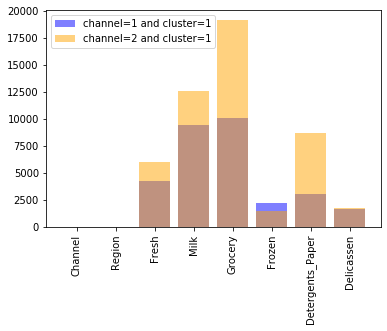

# 問題12 卸売業者にとって有益な情報

チャネル別の傾向<br>
・channel1利用者はfrozenをよく買う。<br>
・channel2利用者はそれ以外の全てのものをchannel1利用者以上に多く買っている。<br>

一方、channelが同じでもクラスタごとに別の傾向が見られる。<br>
クラスタ別の傾向<br>
・クラスタ１はクラスタ２に比較して、FreshとFrozenをよく購入する<br>
・クラスタ2はクラスタ1に比較して、Milk, Grocery, Detergents_Paperをよく購入する<br>